In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

In [10]:
import numpy as np
import pandas as pd
from math import log10
import itertools as it

In [17]:
# utils

def diffs(L):
    return [y-x for (x,y) in zip(L, L[1:])]

def pct_divN(n):
    def closure(seq):
        return np.mean([(x % n) == 0 for x in seq])
    
    return closure
 

In [40]:
def monotonic_inc(seq):
    '''Proportion of the sequence that is weakly monotonically increasing.'''
    return np.mean([x >= 0 for x in diffs(seq)]) if len(seq) > 1 else np.NaN

def concave_up(seq):
    '''Proportion of the sequence whose differences of differences are increasing.'''
    return np.mean([x >= 0 for x in diffs(diffs(seq))]) if len(seq) > 2 else np.NaN

def nonneg(seq):
    '''Proportion of the sequence that is non-negative.'''
    return np.mean(list(x >= 0 for x in seq))

def uniq(seq):
    '''Number of unique values in the sequence.'''
    return len(set(seq))

def length(seq):
    '''Length of the sequence.'''
    return len(seq)

def logmax(seq):
    '''Log of the largest magnitude of all the values in the sequence (plus one).'''
    return log10(np.abs(seq).max() + 1.0)

def pct_div2(seq):
    '''Proportion of the sequence that is divisible by 2 (i.e. even).'''
    return pct_divN(2)(seq)

def pct_div3(seq):
    '''Proportion of the sequence that is divisible by 3.'''
    return pct_divN(3)(seq)


In [41]:
funclist = [monotonic_inc, concave_up, nonneg, uniq, length, logmax, pct_div2, pct_div3]

In [20]:
seqs, feats = {}, {}
with open('../data/raw/sequences') as f:
    for seq in f:
        if seq[0] != '#':
            seq_id, seq_array = seq.split()
            seq_array = [int(x) for x in seq_array.split(',') if x]

            if seq_array:
                seqs[seq_id] = seq_array
                feats[seq_id] = {f.__name__: f(seq_array) for f in funclist}


In [21]:
features = pd.DataFrame(feats).T

# Univariate Analysis

This section contains univariate analyses of the features generated on the integer sequences. 
These features are:

In [61]:
for f in funclist: print('{0:<20}{1}'.format(f.__name__, f.__doc__))

monotonic_inc       Proportion of the sequence that is weakly monotonically increasing.
concave_up          Proportion of the sequence whose differences of differences are increasing.
nonneg              Proportion of the sequence that is non-negative.
uniq                Number of unique values in the sequence.
length              Length of the sequence.
logmax              Log of the largest magnitude of all the values in the sequence (plus one).
pct_div2            Proportion of the sequence that is divisible by 2 (i.e. even).
pct_div3            Proportion of the sequence that is divisible by 3.


### Descriptive Stats

In [22]:
features.describe()

,concave_up,length,logmax,monotonic_inc,nonneg,pct_div2,pct_div3,uniq
count,314580.000000,314701.000000,314701.000000,314692.000000,314701.000000,314701.000000,314701.000000,314701.000000
mean,0.761431,42.165945,10.019568,0.865226,0.979401,0.512920,0.362904,28.118115
std,0.212075,27.845475,12.078406,0.203138,0.098722,0.302083,0.242189,17.929761
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.560000,19.000000,2.409933,0.692308,1.000000,0.350649,0.227273,14.000000
50%,0.734375,36.000000,5.370045,1.000000,1.000000,0.500000,0.333333,24.000000
75%,1.000000,59.000000,14.545476,1.000000,1.000000,0.727273,0.464646,41.000000
max,1.000000,377.000000,284.670750,1.000000,1.000000,1.000000,1.000000,160.000000


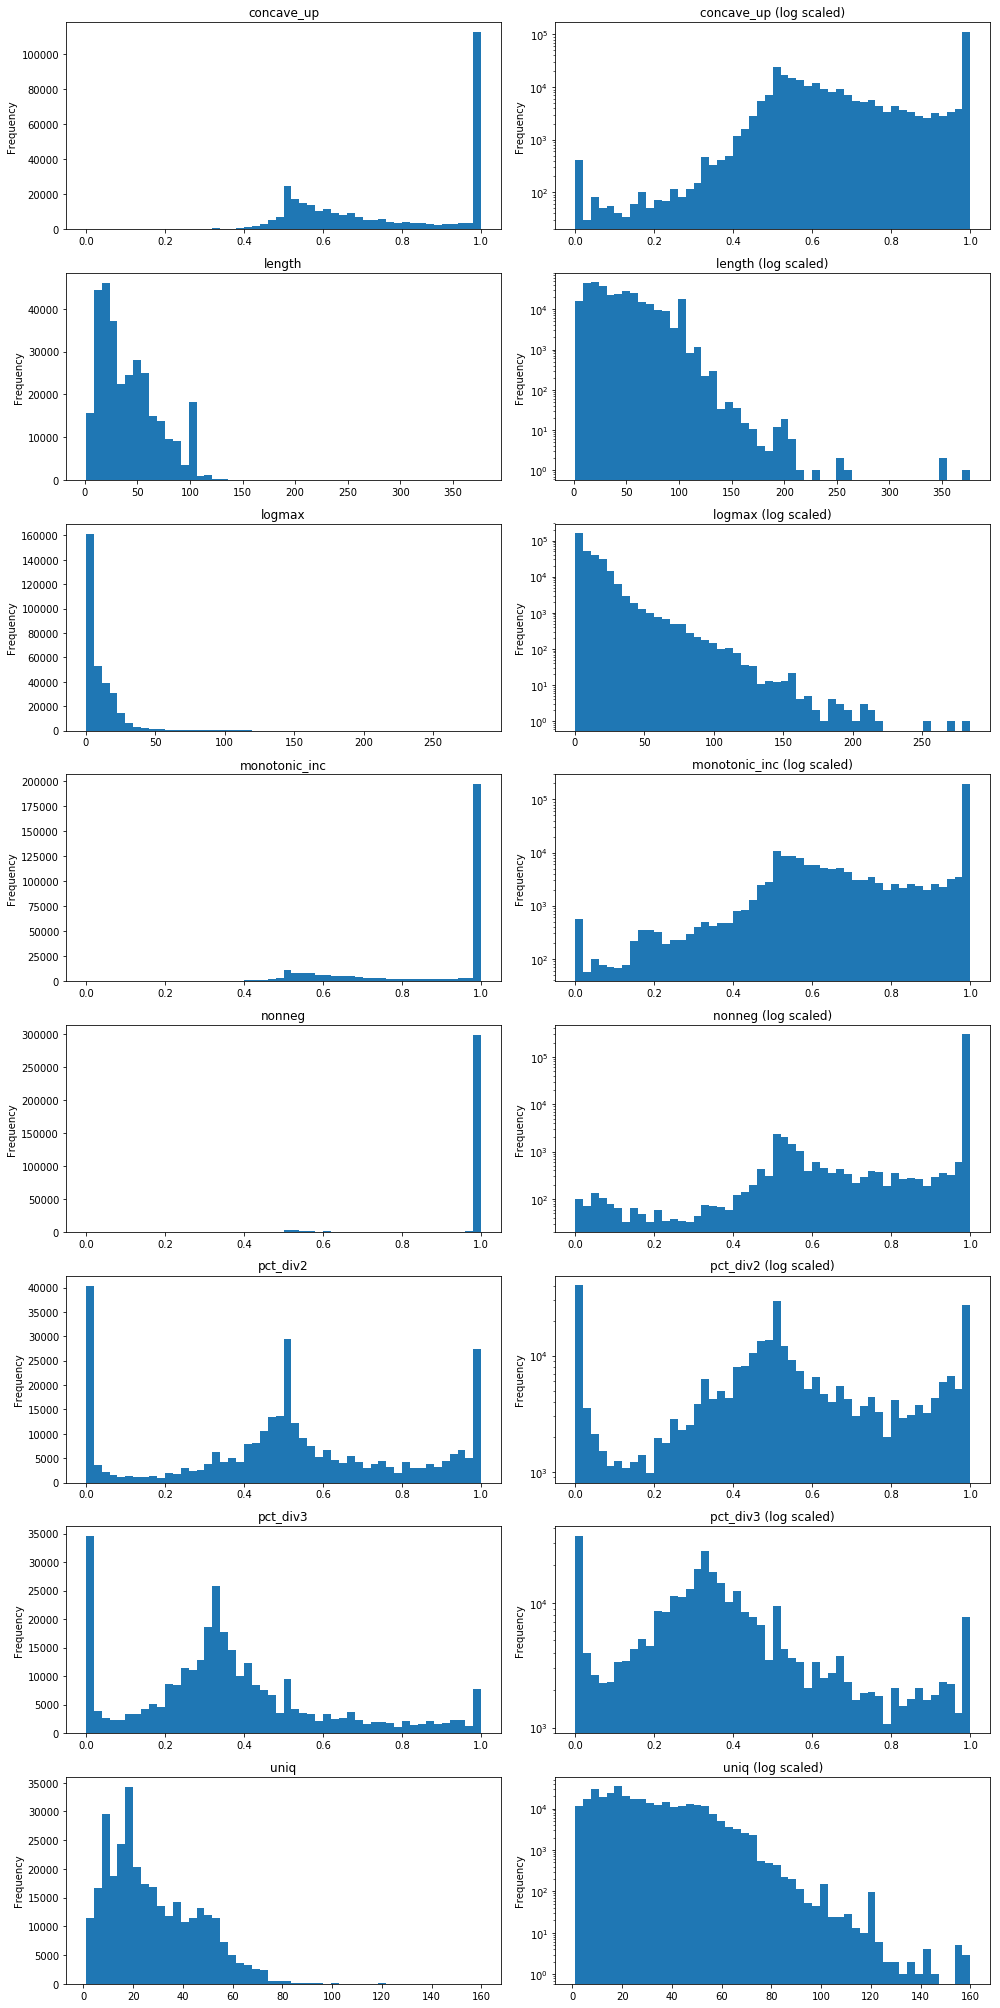

In [73]:
fig, axes = plt.subplots(len(features.columns), 2, figsize=(14,28))
for i, c in enumerate(features.columns):
    features[c].plot(kind='hist', bins=50, ax=axes[i, 0], title=c)
    features[c].plot(kind='hist', bins=50, ax=axes[i, 1], title='%s (log scaled)' %c, logy=True)
    
plt.tight_layout()

### What is that spike in sequences with exactly 10 unique values?

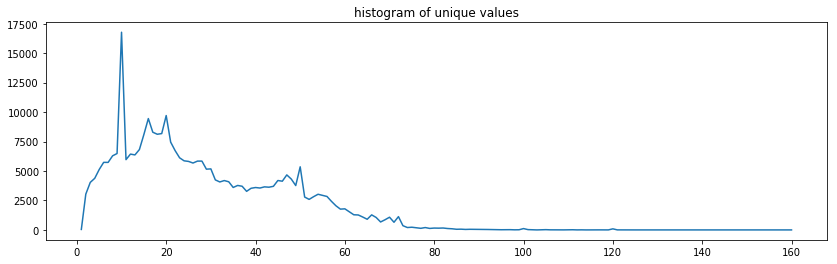

In [78]:
features.uniq.value_counts().sort_index().plot(figsize=(14,4), title='histogram of unique values');

Likely, these are decimal representations of numbers. A better way select the sequences that likely correspond to decimal representations is to select those sequences whose:
* maximum value is less than or equal to 9 (i.e. logmax <= 1).
* is a non-negative sequence.

Here are a number of observations about the variables of these likely decimal representations:
* concave_up: most commonly, this variable is concentrated around 0.5.
* length: concentrated near 100 -- likely just a round number up which to compute the decimal representation.
* monotonic_inc: this variable is concentrated around 0.5 -- and otherwise skewed toward 1.0. The decimal representations have randomly distributed ups and downs?
* pct_div2: sequences tend to have an even mix of even/odd values.
* pct_div3: sequences tend to have ~1/3 of it's values divisible by 3.

In [172]:
poss_dec = (
    features.loc[
        (features.logmax <= 1.0) & 
        (features.nonneg == 1.0) & 
        (features.uniq == 10)
    ].drop(['nonneg', 'uniq', 'logmax'], axis=1)
)

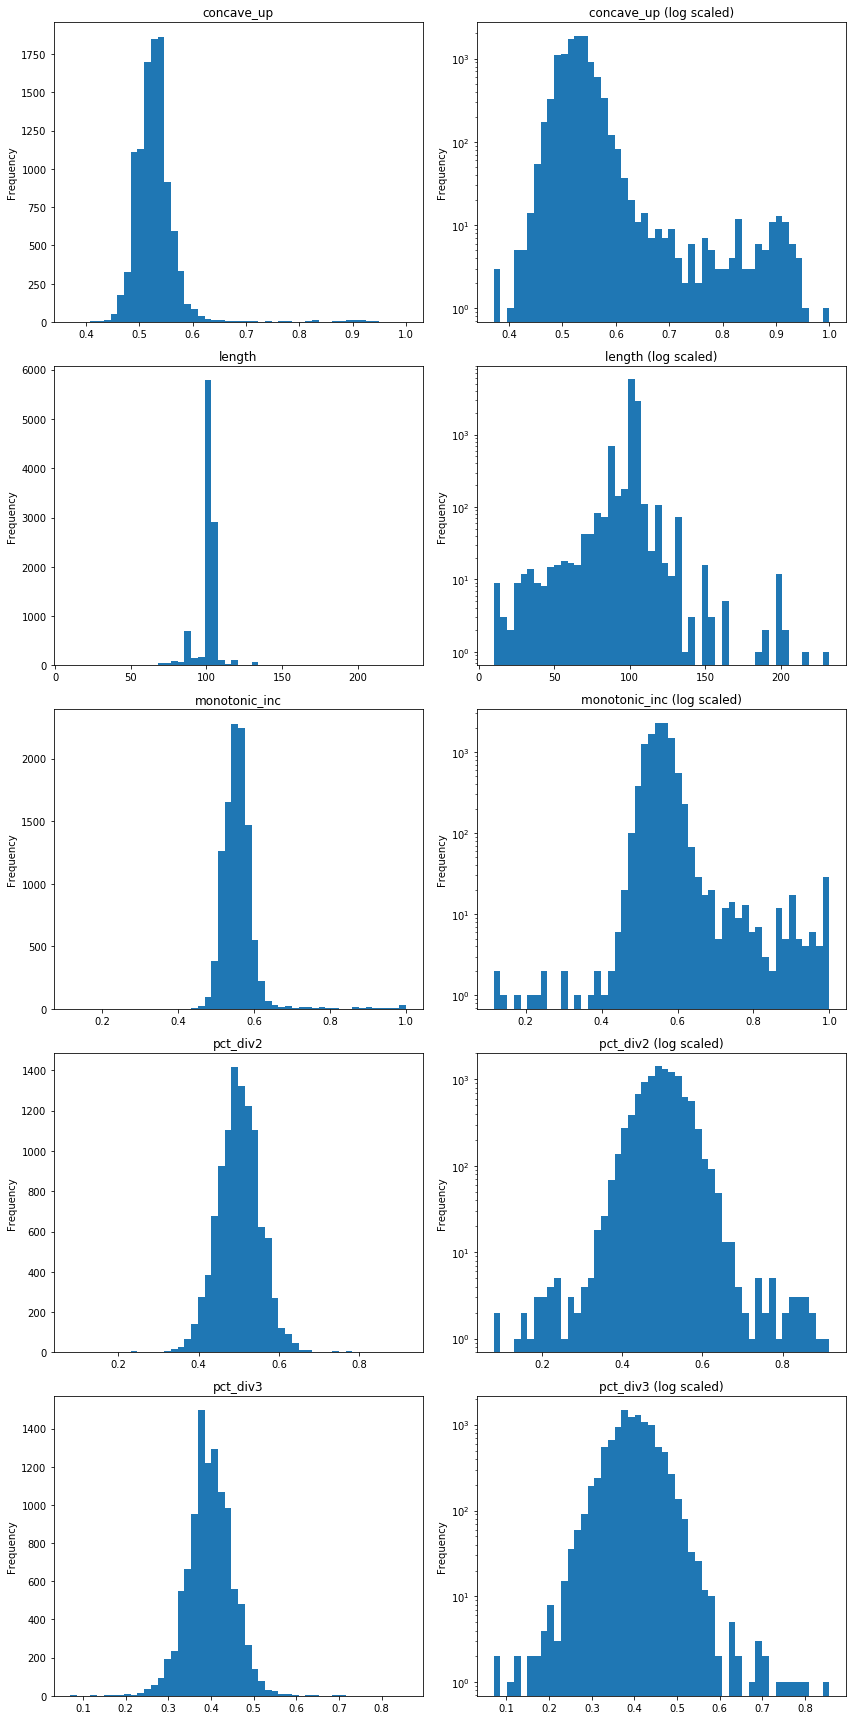

In [173]:
fig, axes = plt.subplots(len(poss_dec.columns), 2, figsize=(12,24))
for i, c in enumerate(poss_dec.columns):
    poss_dec[c].plot(kind='hist', bins=50, ax=axes[i, 0], title=c)
    poss_dec[c].plot(kind='hist', bins=50, ax=axes[i, 1], title='%s (log scaled)' %c, logy=True)
    
plt.tight_layout()

Of the sequences that are likely decimal representations of numbers, the digit-frequency seems to be a distribution centered about 0.1 (sequences with a "random" mix of digits).

In [174]:
cnt_vals = lambda seq: pd.Series(seqs[seq]).value_counts().reindex(index=range(10), fill_value=0).rename(seq)
dec_cnts = pd.concat([cnt_vals(seq) for seq in poss_dec.index], axis=1).T

In [175]:
dec_pcts = dec_cnts.apply(lambda x:x/x.sum(), axis=1)

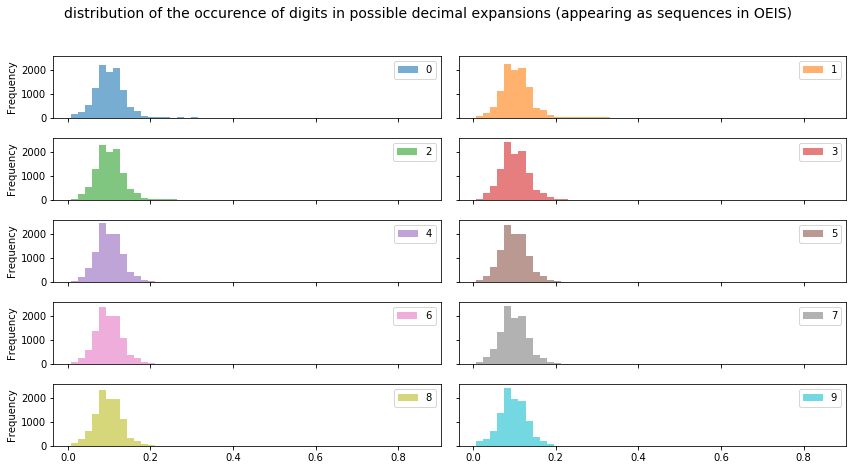

In [176]:
fig, ax = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(12,6))
title = 'distribution of the occurence of digits in possible decimal expansions (appearing as sequences in OEIS)'
fig.suptitle(title, fontsize=14, y=1.08)
dec_pcts.plot(kind='hist', alpha=0.6, bins=50, subplots=True, ax=ax)
plt.tight_layout()
plt.show()